# Choosing gate unit

* train with SimpleRNN / LSTM / GRU gates

In [10]:
import os
import re
import time
from tqdm import tqdm

import keras
from keras.activations import tanh as Tanh
from keras.layers import Activation, Add, Dense, Embedding, Masking
from keras.layers import Input, SimpleRNN, LSTM, GRU
from keras.models import Model
from keras import regularizers
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.utils import to_categorical 
keras.backend.set_epsilon(1e-16)
import nltk
import numpy as np
keras.__version__
nltk.download('punkt')
nltk.download('wordnet')


import re, string, unicodedata
import nltk
import contractions
import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

[nltk_data] Downloading package punkt to /home/railway/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/railway/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
# DATASET PATHS
fasttext_enbeddings = "../../data/embeddings/fasttext/multi/wiki.multi.es.vec"
TRAIN_SENTENCES = "../../data/semeval/en/en-sentences-train.txt"
TRAIN_LABELS = "../../data/semeval/en/en-labels-train.txt"
TEST_SENTENCES = "../../data/semeval/en/en-sentences-test.txt"
TEST_LABELS = "../../data/semeval/en/en-labels-test.txt"

In [12]:
# READ DATASET FUNCTIONS
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

def preprocess_text(text):
    text = denoise_text(text)
    text = replace_contractions(text)
    return text

def split_into_words(text):
    return nltk.word_tokenize(text)

""" WORD LEVEL - NORMALIZATION """
# words = nltk.word_tokenize(sample)

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word, comma=".")
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = lemmatize_verbs(words)
    return words

def read_labels(file_path):
    with open(file_path, "r") as labs_f:
        labels = [float(l.strip('\n')) for l in labs_f]
    return labels

def to_categorical_fractions(labels):
    # deal with fractional annotations in labels
    categories_num = to_categorical(labels).shape[1]
    results = []
    for lab in labels:
        major_label = int(lab)
        minor_label = major_label + 1
        minor_weight = lab - major_label
        major_weight = 1 - minor_weight
        cur_result = np.zeros(categories_num)
        cur_result[major_label] = major_weight
        if minor_weight > 0:
            cur_result[minor_label] = minor_weight
        results.append(cur_result)
    return np.array(results)

def read_linear_dataset(dataset_path):
    # return array of sentense pairs and vocabulary
    with open(dataset_path, "r") as ds_f:
        result = [[],[]]
        for line in ds_f:
            cur_line = line.split("\t")
            assert len(cur_line) == 2
            sent1 = cur_line[0].strip(" ")
            sent1 = preprocess_text(sent1)
            sent1 = split_into_words(sent1)
            sent1 = normalize(sent1)
            result[0].append(sent1)
            sent2 = preprocess_text(cur_line[1].strip("\n").strip(" "))
            sent2 = split_into_words(sent2)
            sent2 = normalize(sent2)
            result[1].append(sent2)
    return result

def get_embeddings(embeddings_path, words_num=None):
    # adapted to FastText embeddings
    with open(embeddings_path, "r") as emb_f:
        word2vec = {}
        for i, line in enumerate(emb_f):
            line = line.strip("\n").split(" ")
            if i == 0:
                total_word_num = int(line[0])
                words_num = words_num if total_word_num > words_num else total_word_num
                continue
            if line[0] in word2vec:
                print(line[0] + " is in vocab!. Vocab len: " + str(len(word2vec)))
            word2vec[line[0]] = np.asarray(line[1:], dtype='float32')
            if i == words_num:
                break
    return word2vec

### READ DATASET

In [13]:
MAX_SEQUENCE_LENGTH = 80
VALIDATION_SPLIT = 0.1
EMBEDDING_DIM = 300

# read embeddings -> dict(word : vector)
embeddings_index = get_embeddings(fasttext_enbeddings, words_num=250000)
# read labels
train_labels = read_labels(TRAIN_LABELS)
test_labels = read_labels(TEST_LABELS)
train_labels = to_categorical_fractions(train_labels)
test_labels = to_categorical_fractions(test_labels)
print(f"train_labels - shape: {train_labels.shape}, type {type(train_labels)}")
print(f"test_labels - shape: {test_labels.shape}, type {type(test_labels)}")
print(f"embeddings_index - type {type(embeddings_index)} - length {len(embeddings_index)}")
print(f"train_label example - {train_labels[2]}")
print(f"test_label example - {test_labels[2]}")

# read dataset -> list(sentence_str1, sentence_str2)
train_dataset = read_linear_dataset(TRAIN_SENTENCES)
test_dataset = read_linear_dataset(TEST_SENTENCES)

print(f"train_dataset - type: {type(train_dataset)}, len: {len(train_dataset)}")
print(f"test_dataset - type: {type(test_dataset)}, len: {len(test_dataset)}")
print(f"\ntrain_dataset - 5 first sentence pair lengths: ", end="")
print([(len(train_dataset[0][i]), len(train_dataset[1][i])) for i in range(5)])
print(f"test_dataset - 5 first sentence pair lengths: ", end="")
print([(len(test_dataset[0][i]), len(test_dataset[1][i])) for i in range(5)])

print("\n- train_dataset example pair -")
print(train_dataset[0][0])
print(train_dataset[1][0])
print("- test_dataset example pair -")
print(test_dataset[0][8])
print(test_dataset[1][8])


tokenizer = Tokenizer(filters="", lower=False, split=' ')
tokenizer.fit_on_texts(list(embeddings_index.keys()))

sequences_1 = tokenizer.texts_to_sequences(train_dataset[0])
sequences_2 = tokenizer.texts_to_sequences(train_dataset[1])
test_sequences_1 = tokenizer.texts_to_sequences(test_dataset[0])
test_sequences_2 = tokenizer.texts_to_sequences(test_dataset[1])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print(list(word_index.items())[:10])

data_1 = pad_sequences(sequences_1, maxlen=MAX_SEQUENCE_LENGTH, padding = 'pre')
data_2 = pad_sequences(sequences_2, maxlen=MAX_SEQUENCE_LENGTH, padding = 'pre')
test_data_1 = pad_sequences(test_sequences_1, maxlen=MAX_SEQUENCE_LENGTH, padding = 'pre')
test_data_2 = pad_sequences(test_sequences_2, maxlen=MAX_SEQUENCE_LENGTH, padding = 'pre')
assert len(data_1) == len(data_2)
assert len(test_data_1) == len(test_data_2)

data = [data_1, data_2]
test_data = [test_data_1, test_data_2]
print(f"Shapes of train data tensors: {data[0].shape}, {data[0].shape}")
print(f"Shapes of test data tensors: {test_data[0].shape}, {test_data[0].shape}")
print(f"Shape of train label tensor: {train_labels.shape}")
print(f"Shape of test label tensor: {test_labels.shape}")

print(data[0][0])
print(data[1][0])

# embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

train_labels - shape: (2234, 6), type <class 'numpy.ndarray'>
test_labels - shape: (1959, 6), type <class 'numpy.ndarray'>
embeddings_index - type <class 'dict'> - length 250000
train_label example - [0.  0.  0.2 0.8 0.  0. ]
test_label example - [0.  0.  0.  0.4 0.6 0. ]
train_dataset - type: <class 'list'>, len: 2
test_dataset - type: <class 'list'>, len: 2

train_dataset - 5 first sentence pair lengths: [(29, 24), (11, 17), (17, 20), (21, 30), (19, 19)]
test_dataset - 5 first sentence pair lengths: [(15, 19), (18, 21), (25, 22), (22, 17), (17, 14)]

- train_dataset example pair -
['but', 'other', 'source', 'close', 'to', 'the', 'sale', 'say', 'vivendi', 'be', 'keep', 'the', 'door', 'open', 'to', 'further', 'bid', 'and', 'hop', 'to', 'see', 'bidders', 'interest', 'in', 'individual', 'assets', 'team', 'up', '.']
['but', 'other', 'source', 'close', 'to', 'the', 'sale', 'say', 'vivendi', 'be', 'keep', 'the', 'door', 'open', 'for', 'further', 'bid', 'in', 'the', 'next', 'day', 'or', 'two

## Model

In [17]:
# Measure
def pearson_r(y_true, y_pred):
    # https://github.com/WenYanger/Keras_Metrics/blob/master/PearsonCorr.py
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x - mx, y - my
    r_num = K.sum(xm * ym)
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = K.sqrt(x_square_sum * y_square_sum)
    r = r_num / r_den
    return K.mean(r)

# Model
def one_layer_simple_rnn_model(rnn_gate):

    embedding_layer = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix],
                                  input_length=MAX_SEQUENCE_LENGTH, trainable=False, name="embedding_layer")
    masking_layer = Masking(mask_value=0, name="masking_layer")
    no_activation_dense = Dense(EMBEDDING_DIM, activation=None)

    x1 = Input(shape=(None,), dtype='int32', name="x1")
    masked_1 = masking_layer(x1)
    embedded_sequences_1 = embedding_layer(masked_1)
    h11 = rnn_gate(embedded_sequences_1)

    x2 = Input(shape=(None,), dtype='int32', name="x2")
    masked_2 = masking_layer(x2)
    embedded_sequences_2 = embedding_layer(masked_2)
    h21 = rnn_gate(embedded_sequences_2)
    
    S11 = no_activation_dense(h11)
    S12 = no_activation_dense(h21)
    s1 = Add(name="concat_layer")([S11, S12])
    s1 = Activation('tanh', name="output_activation")(s1)
    s2 = Dense(6, activation='softmax', name="output_layer")(s1)

    model = Model(inputs=[x1, x2], outputs=s2)
    return model


model_test = one_layer_simple_rnn_model(LSTM(10))
model_test.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x1 (InputLayer)                 (None, None)         0                                            
__________________________________________________________________________________________________
x2 (InputLayer)                 (None, None)         0                                            
__________________________________________________________________________________________________
masking_layer (Masking)         (None, None)         0           x1[0][0]                         
                                                                 x2[0][0]                         
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 80, 300)      75000300    masking_layer[0][0]              
          

## Experiments

### Choosing of the recurrent gate unit

In [33]:
histories = []
epochs_num = 12
batch_size = 1
verbosity = 2
run_times = 3
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)

simple_gate = SimpleRNN(EMBEDDING_DIM, activation='tanh', use_bias=True, activity_regularizer=regularizers.l2(0.001))
lstm_gate = LSTM(EMBEDDING_DIM, activation='tanh', use_bias=True, activity_regularizer=regularizers.l2(0.001))
gru_gate = GRU(EMBEDDING_DIM, activation='tanh', use_bias=True, activity_regularizer=regularizers.l2(0.001))

main_val_list = [simple_gate, lstm_gate, gru_gate]
start_time = time.time()
for cur_value in main_val_list:
    cur_mean_hist = {}
    for i in range(run_times):
        print(f"\n- Training for value {cur_value} - run {i+1} ", end = "")
        model = one_layer_simple_rnn_model(cur_value)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[pearson_r])
        val_data = (test_data, test_labels)
        cur_hist = model.fit(data, train_labels,
                             validation_data=val_data,
                             epochs=epochs_num, verbose=verbosity, batch_size=batch_size)
        for k, v in cur_hist.history.items():
            v = np.array(v)
            if k not in cur_mean_hist:
                cur_mean_hist[k] = v / run_times
            else:
                cur_mean_hist[k] += v / run_times
            if k == "val_pearson_r":
                print(f"max val_pearson_r - {v.max()} at index {v.argmax()}")
    histories.append(cur_mean_hist)
    print("mean max val_pearson_r - {} at {}".format(
        np.max(cur_mean_hist['val_pearson_r']), np.argmax(cur_mean_hist['val_pearson_r'])))
    
elapsed_time = int((time.time() - start_time) / 60)
print(f"time spent - total {elapsed_time} min, average {elapsed_time/len(main_val_list)/run_times}")


- Training for value <keras.layers.recurrent.SimpleRNN object at 0x7f82ff912470> - run 1 Train on 2234 samples, validate on 1959 samples
Epoch 1/12
 - 52s - loss: 2.5920 - pearson_r: 0.1453 - val_loss: 2.4424 - val_pearson_r: 0.2124
Epoch 2/12
 - 49s - loss: 2.3601 - pearson_r: 0.1716 - val_loss: 2.2672 - val_pearson_r: 0.2279
Epoch 3/12
 - 50s - loss: 2.3201 - pearson_r: 0.1851 - val_loss: 2.5234 - val_pearson_r: 0.1668
Epoch 4/12
 - 50s - loss: 2.2951 - pearson_r: 0.2065 - val_loss: 2.2280 - val_pearson_r: 0.2513
Epoch 5/12
 - 48s - loss: 2.0749 - pearson_r: 0.2596 - val_loss: 2.1247 - val_pearson_r: 0.0602
Epoch 6/12
 - 50s - loss: 2.0167 - pearson_r: 0.2775 - val_loss: 2.0137 - val_pearson_r: 0.2416
Epoch 7/12
 - 49s - loss: 1.9959 - pearson_r: 0.2846 - val_loss: 2.0298 - val_pearson_r: 0.2471
Epoch 8/12
 - 50s - loss: 1.9813 - pearson_r: 0.2932 - val_loss: 1.9906 - val_pearson_r: 0.2593
Epoch 9/12
 - 49s - loss: 1.9722 - pearson_r: 0.2974 - val_loss: 1.9831 - val_pearson_r: 0.261

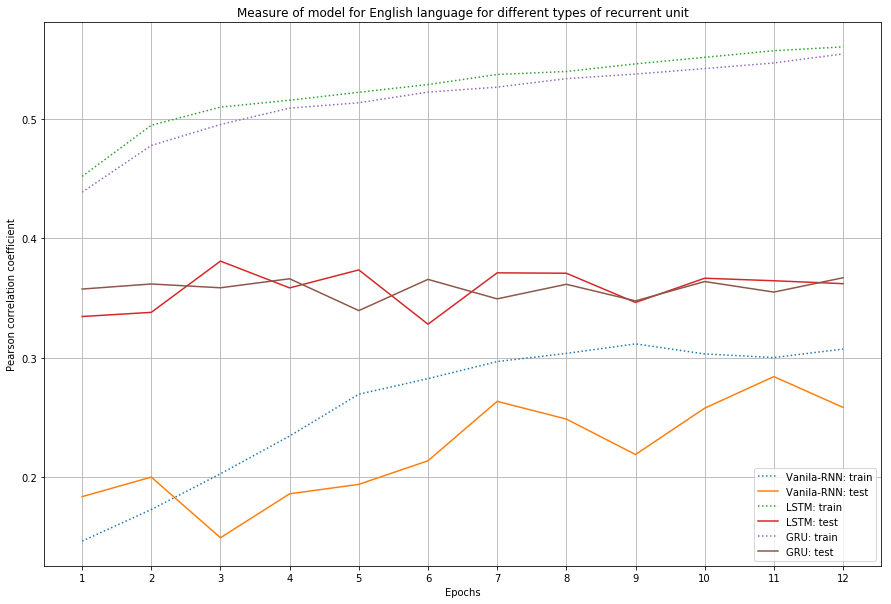

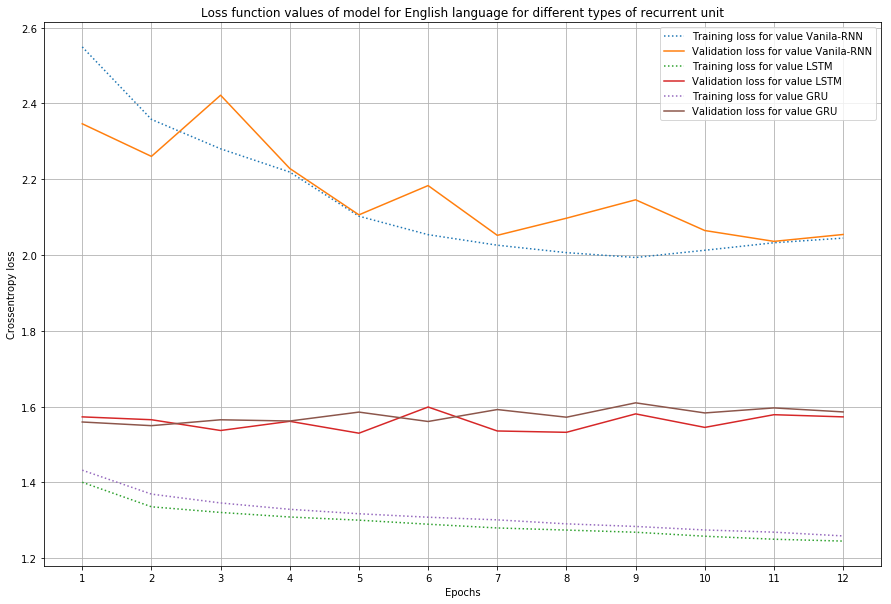

In [51]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15,10)

main_val_list = ["Vanila-RNN", "LSTM", "GRU"]
epochs = list(range(epochs_num))
for cur_mom, cur_hist in zip(main_val_list, histories):
    acc = cur_hist['pearson_r']
    val_acc = cur_hist['val_pearson_r']
    plt.plot([e+1 for e in epochs], acc, linestyle=':', label=f'{cur_mom}: train')
    plt.plot([e+1 for e in epochs], val_acc, label=f'{cur_mom}: test')
    plt.xticks([e+1 for e in epochs])
    plt.xlabel("Epochs")
    plt.ylabel("Pearson correlation coefficient")
    plt.title("Measure of model for English language for different types of recurrent unit")
    plt.legend()
    plt.grid(b=True)
plt.savefig(f'choise-of-rnn-gate_training-output_pearson.png', bbox_inches='tight')

plt.figure()
for cur_mom, cur_hist in zip(main_val_list, histories):
    loss = cur_hist['loss']
    val_loss = cur_hist['val_loss']
    plt.plot([e+1 for e in epochs], loss, linestyle=':', label=f'Training loss for value {cur_mom}')
    plt.plot([e+1 for e in epochs], val_loss, label=f'Validation loss for value {cur_mom}')
    plt.xticks([e+1 for e in epochs])
    plt.xlabel("Epochs")
    plt.ylabel("Crossentropy loss")
    plt.title('Loss function values of model for English language for different types of recurrent unit')
    plt.legend()
    plt.grid(b=True)
plt.savefig(f'choise-of-rnn-gate_training-output_loss.png', bbox_inches='tight')
plt.show()


In [45]:
# save json dumps of experiment
import json
OUT_PATH = "experiments/choise-of-rnn_histories-for-plots.json"

gate_types = ["Vanila-RNN", "LSTM", "GRU"]
new_histories = {}
for gate, cur_hist in zip(gate_types, histories):
    new_cur_hist = {}
    for k, v in cur_hist.items():
        new_cur_hist[k] = v.tolist()
    new_histories[gate] = new_cur_hist
with open(OUT_PATH, 'w') as outfile:
    json.dump(new_histories, outfile, indent=4)